# EDA
El objetivo de este notebook es realizar un análisis explorativo de datos, y usar este análisis para limpiar más los datos y/o preprocesarlos

In [65]:
from src.data_processing import standardize_features, log_transform_features, cap_outliers
%load_ext autoreload
%autoreload 2

import pandas as pd

from src.utils import DEV_SET_CLEAN_PATH, TARGET
from src.plots import plot_boolean_impact, plot_correlation_heatmap, plot_histograms, plot_boxplots, plot_bar_charts, \
    plot_geo_scatterplot, plot_categorical_impact, plot_median_price_impact

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
df = pd.read_csv("../" + DEV_SET_CLEAN_PATH)

In [4]:
df.describe(include="all")

,id_grid,STotalM2,SConstrM2,Dormitorios,Banos,Ambientes,Amoblado,Antiguedad,BusinessCenter,Gimnasio,...,ITE_ADD_STATE_NAME,ITE_ADD_NEIGHBORHOOD_NAME,ITE_TIPO_PROD,LONGITUDE,LATITUDE,precio_pesos_constantes,year,SUM,meses_desde_comienzo,mes_listing
count,270715.000000,2.625630e+05,2.637050e+05,270593.000000,270713.000000,269365.000000,240403,2.462150e+05,203480,238431,...,270715,258095,270715,270715.000000,270715.000000,2.707150e+05,270715.000000,214480,270715.000000,270715.000000
unique,NaN,NaN,NaN,NaN,NaN,NaN,2,NaN,2,2,...,4,503,3,NaN,NaN,NaN,NaN,2,NaN,NaN
top,NaN,NaN,NaN,NaN,NaN,NaN,False,NaN,False,False,...,Capital Federal,Palermo,U,NaN,NaN,NaN,NaN,False,NaN,NaN
freq,NaN,NaN,NaN,NaN,NaN,NaN,220227,NaN,202323,209818,...,153869,15541,198204,NaN,NaN,NaN,NaN,176426,NaN,NaN
mean,59783.357649,3.966948e+03,1.720614e+03,1.415528,1.335315,2.402862,NaN,2.907292e+01,NaN,NaN,...,NaN,NaN,NaN,-58.481007,-34.598213,8.215410e+04,2021.472172,NaN,11.152702,6.521190
std,14743.238038,9.779880e+05,4.121375e+05,1.025419,1.030387,1.391798,NaN,4.419469e+03,NaN,NaN,...,NaN,NaN,NaN,0.115097,0.081543,6.757349e+05,0.499226,NaN,6.845461,3.439394
min,124.000000,1.000000e+00,1.000000e+00,0.000000,0.000000,1.000000,NaN,0.000000e+00,NaN,NaN,...,NaN,NaN,NaN,-58.874595,-34.923504,4.264038e+01,2021.000000,NaN,0.000000,1.000000
25%,53517.000000,3.900000e+01,3.700000e+01,1.000000,1.000000,2.000000,NaN,0.000000e+00,NaN,NaN,...,NaN,NaN,NaN,-58.543363,-34.632289,6.568300e+03,2021.000000,NaN,4.960578,4.000000
50%,60080.000000,5.000000e+01,4.600000e+01,1.000000,1.000000,2.000000,NaN,7.000000e+00,NaN,NaN,...,NaN,NaN,NaN,-58.449924,-34.597885,9.166979e+03,2021.000000,NaN,10.972405,7.000000
75%,65657.000000,7.800000e+01,7.000000e+01,2.000000,1.000000,3.000000,NaN,3.000000e+01,NaN,NaN,...,NaN,NaN,NaN,-58.400915,-34.566651,1.866683e+04,2022.000000,NaN,16.951380,9.000000


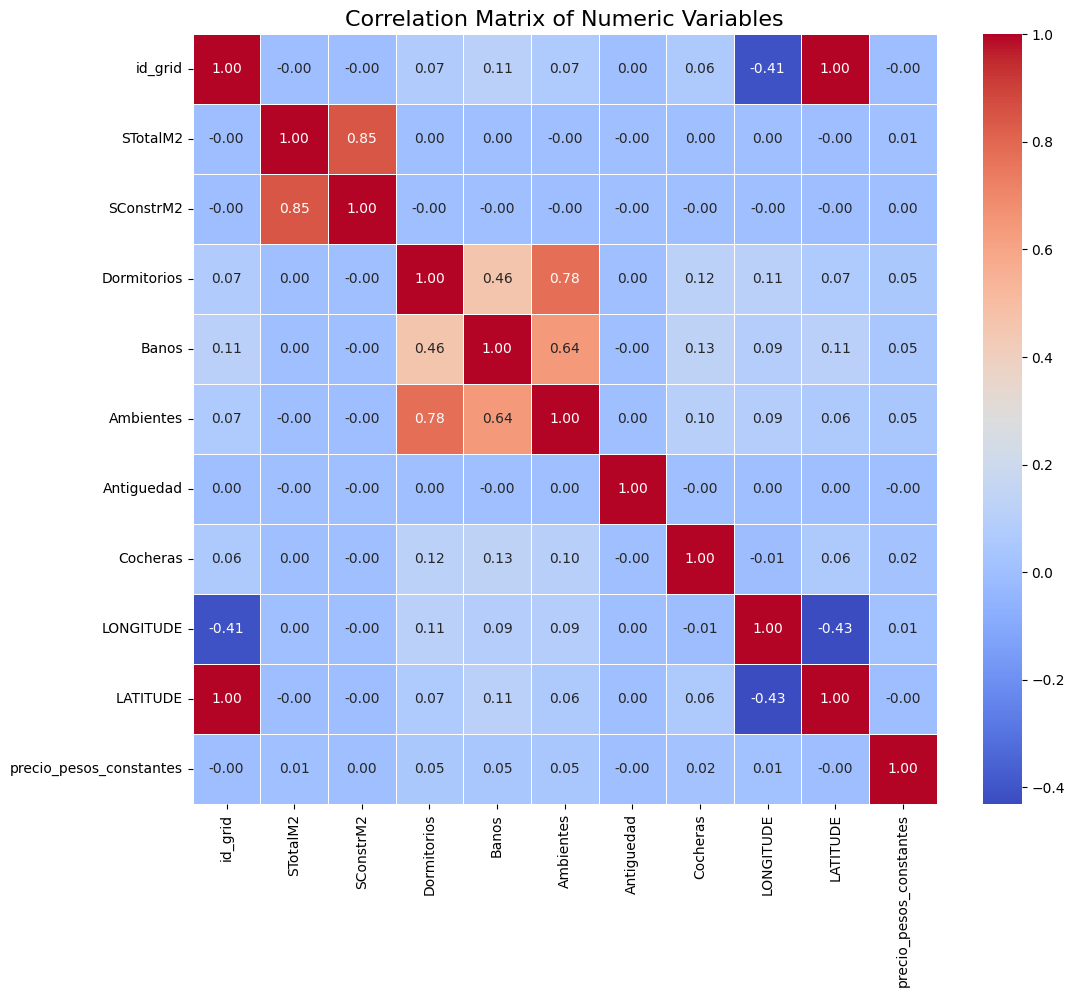

In [5]:
NUMERICAL_FEATURES = ["id_grid", "STotalM2", "SConstrM2", "Dormitorios", "Banos", "Ambientes", "Antiguedad", "Cocheras", "LONGITUDE", "LATITUDE"]
plot_correlation_heatmap(df, NUMERICAL_FEATURES + [TARGET])

A priori, no hay correlación alguna entre las variables y el targer, para ninguna feature. Esto probablemente se deba a outliers extremos, escalas muy diferentes, distribuciones sesgadas. Tenemos que trabajar el dataset antes de seguir analizando

## Análisis de Precio
Análicemos un poco la variable objetivo:

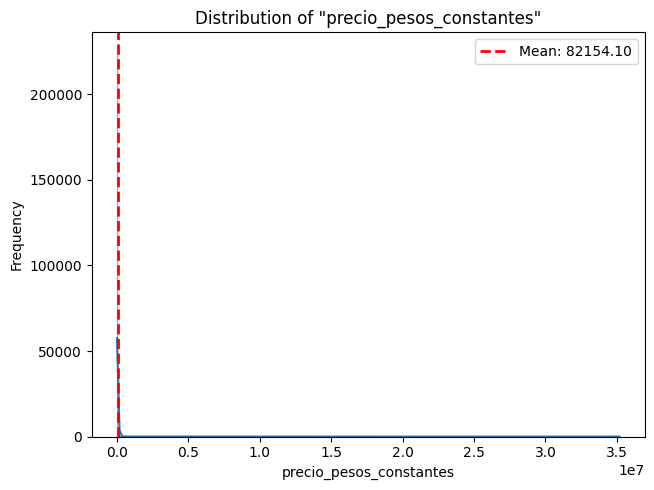

In [6]:
plot_histograms(df, [TARGET])

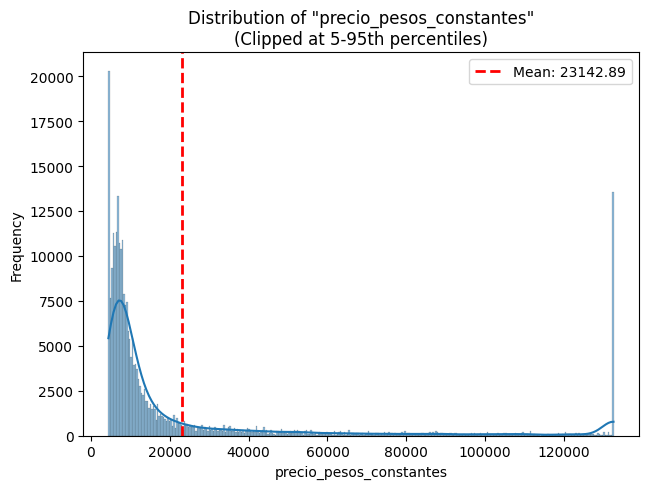

In [7]:
plot_histograms(df, [TARGET], clip_percentiles=(0.05, 0.95))

La variable objetivo (precio) está extremadamente sesgada hacia la izquierda. Esto quiere decir que la mayoría de los precios se encuentran en esa zona, mientras que hay unas pocas propiedades que tienen precios extremadamente altos. Veamos qué pasa si aplicamos el log:

In [8]:
df_log_precio = log_transform_features(df, [TARGET])

Applying log transformation to columns: precio_pesos_constantes


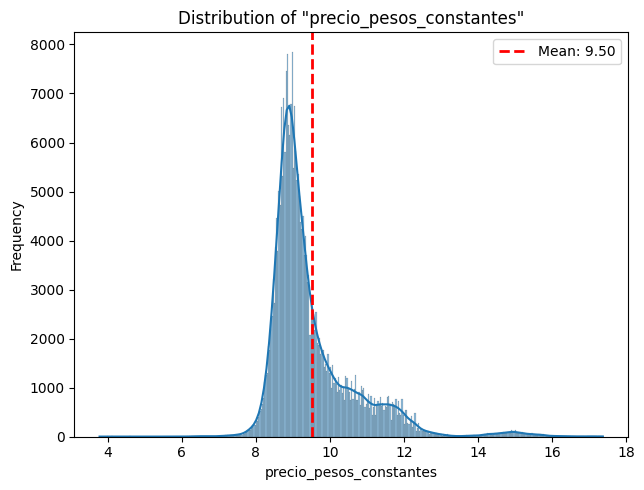

In [9]:
plot_histograms(df_log_precio, [TARGET])

La distribución de log(precio) es mucho más simpetrica y parecida a una distribución normal. Vamos a hacer que nuestro modelo prediga log(precio), lo cual va a facilitar mucho las predicciones.

## Análisis de Features Numéricas
Analicemos la distribución del resto de features numéricas:

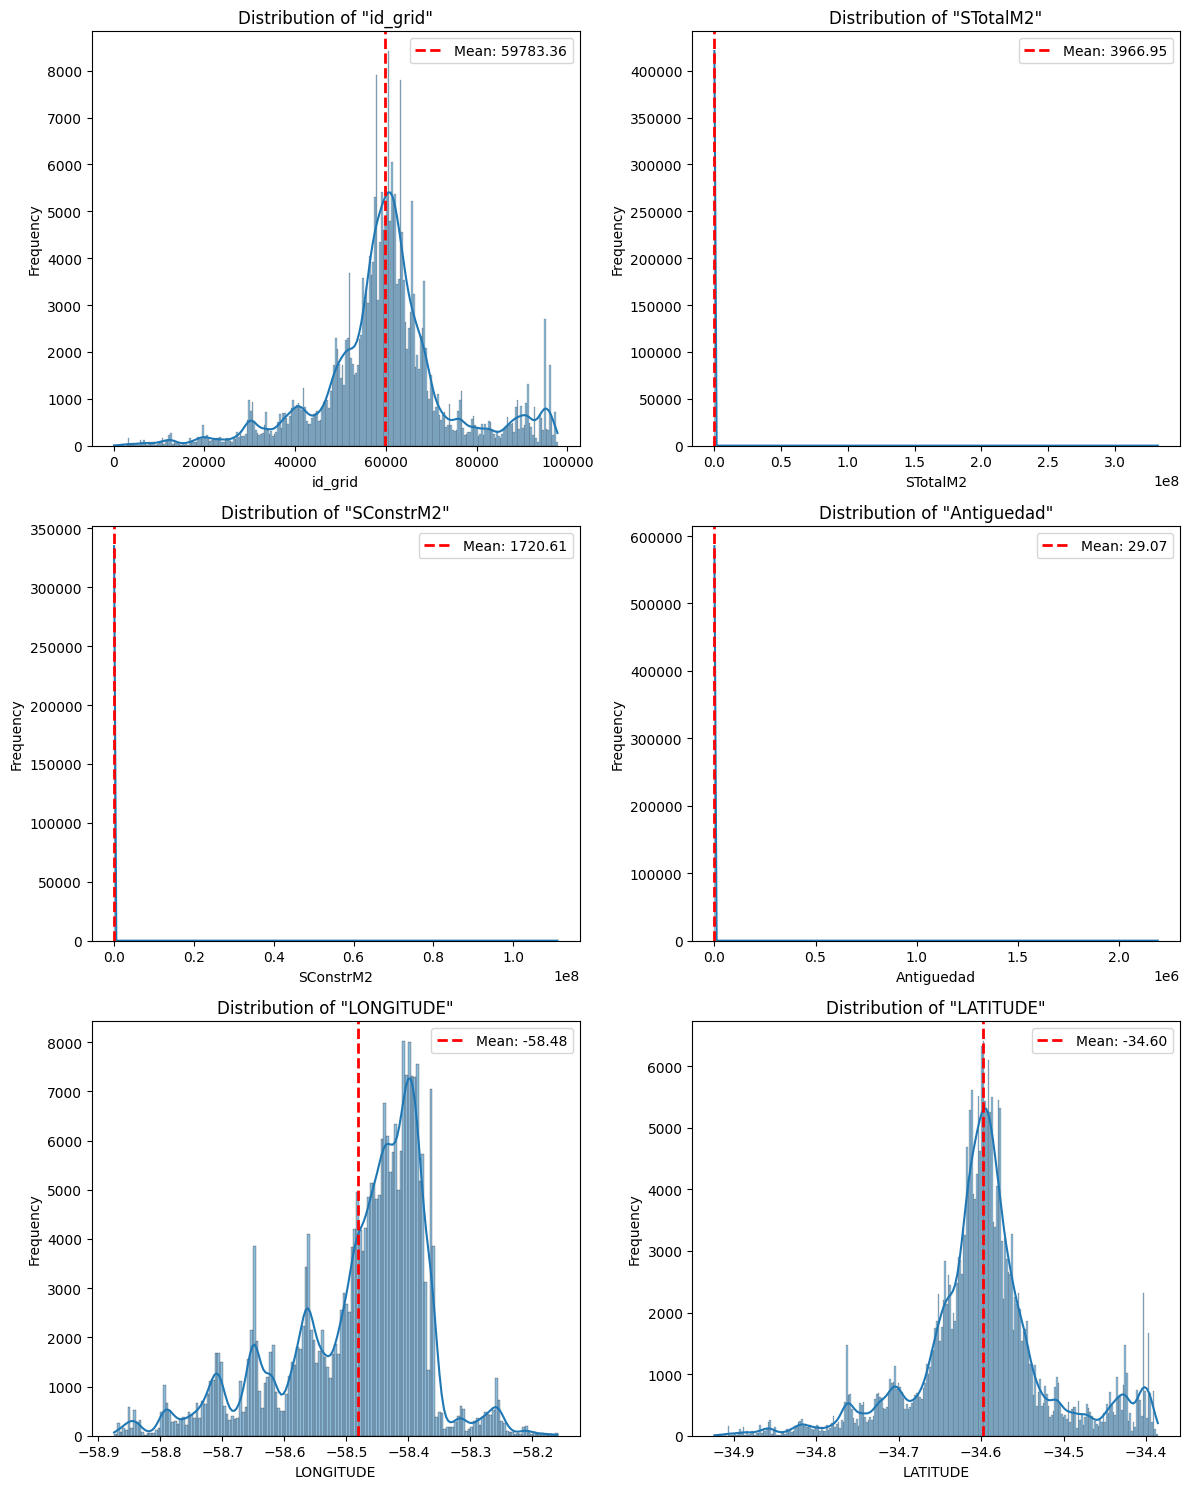

In [27]:
plot_histograms(df_log_precio, NUMERICAL_FEATURES, n_cols=2)

La mayoría de features muestran una asimetría extrema. La mayoría de valores se encuentran a la

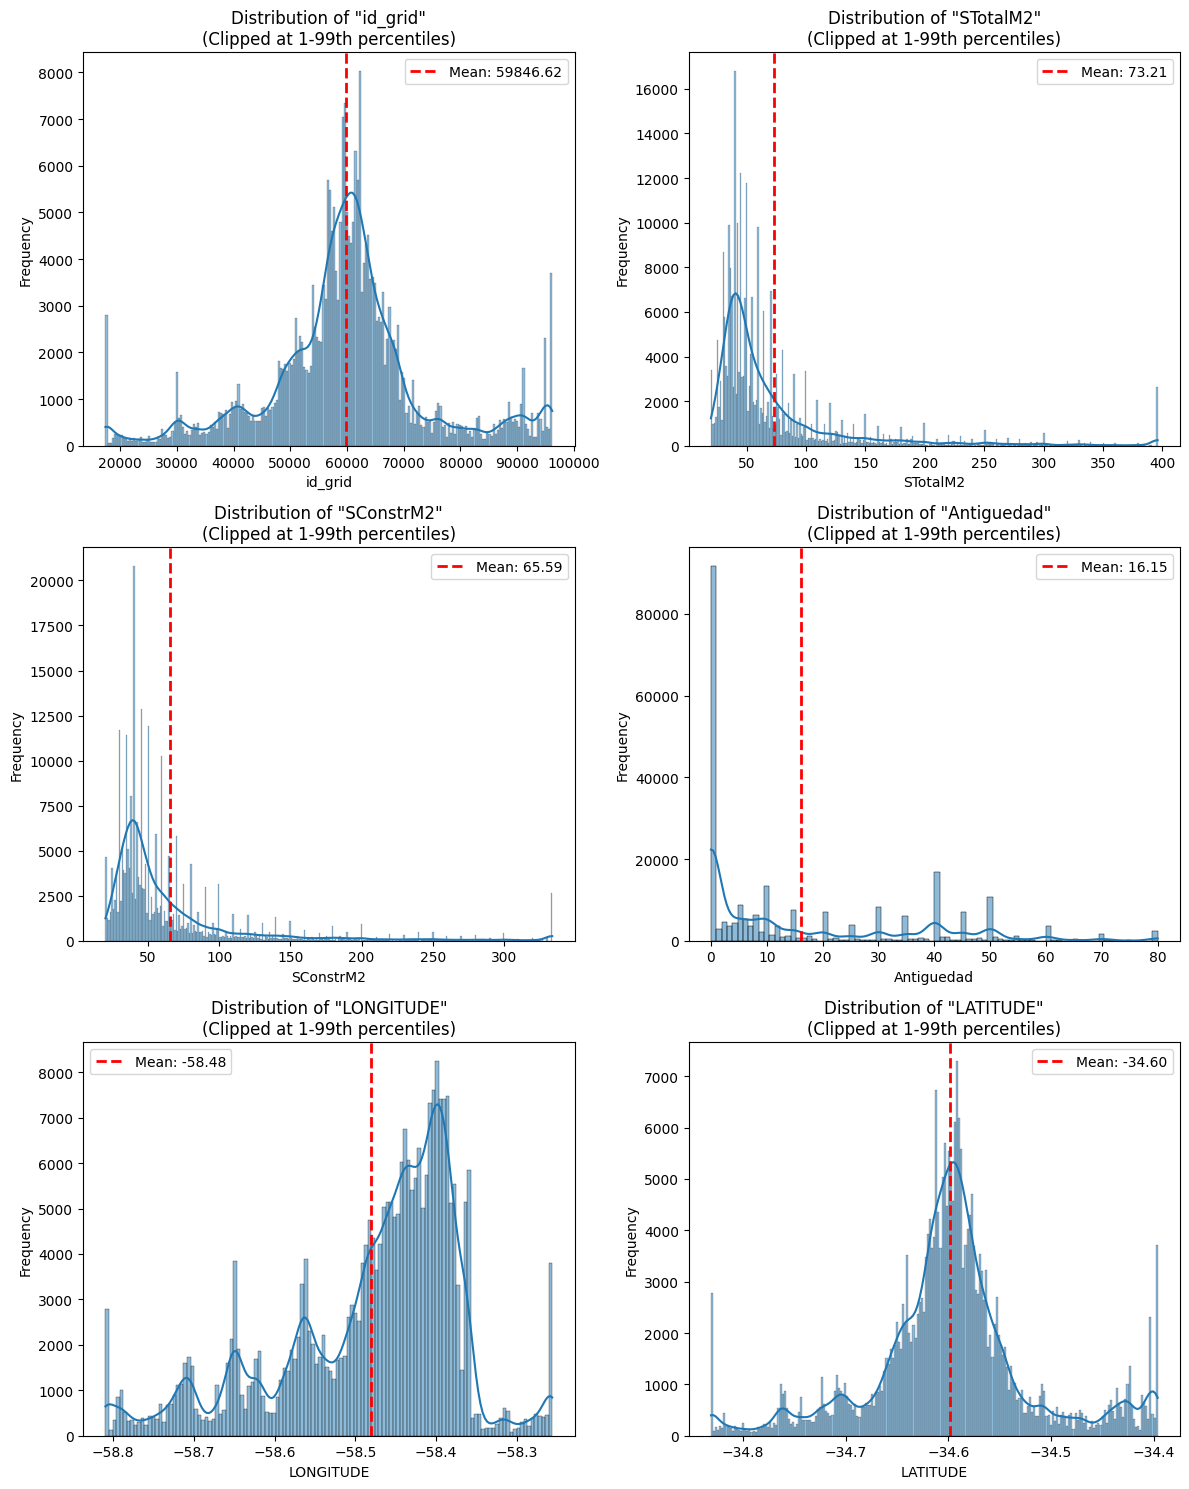

In [28]:
plot_histograms(df_log_precio, NUMERICAL_FEATURES, clip_percentiles=(0.01, 0.99), n_cols=2)

Al excluir los valores realmente extremos, vemos que muchas variables pasan de ser aparentemente numéricas a categóricas. Esto sucede con Dormitorios, Banos, Ambientes, Cocheras. Al excluir outliers extremos, estas variables se mueven únicamente en valores discretos entre 0 y 6. Por ello, asumimos que esos valores extremos (que aplican solo a algunos datos) son erróneos. Vamos a capearlos al percentil más cercano

In [29]:
OUTLIER_COLS = ["Dormitorios", "Banos", "Ambientes", "Cocheras"]
df_capped, _ = cap_outliers(df_log_precio, OUTLIER_COLS, percentiles=(0.01, 0.99))

Capping outliers for columns: Dormitorios, Banos, Ambientes, Cocheras


Además, actualizamos nuestras columnas numéricas para no incluir las recién nombradas (pues pasan a ser categóricas al tener solo algunos valores posibles)

In [13]:
NUMERICAL_FEATURES = ["id_grid", "STotalM2", "SConstrM2", "Antiguedad", "LONGITUDE", "LATITUDE"]
CATEGORICAL_FEATURES = ["Dormitorios", "Banos", "Ambientes", "Amoblado", "BusinessCenter", "Gimnasio", "Laundry", "Calefaccion", "AireAC", "Recepcion", "Estacionamiento", "Jacuzzi", "Seguridad", "Pileta", "Cocheras", "CanchaTennis", "ITE_ADD_STATE_NAME", "ITE_TIPO_PROD", "year", "meses_desde_comienzo", "mes_listing"]

Todavía tenemos problemas con algunas variables numéricas. Por ejemplo, la superficie y antigüedad están muy sesgadas y afectadas por outliers. Veamos si aplicar una transformación logarítmica ayuda a mejorar esto

Applying log transformation to columns: STotalM2, SConstrM2, Antiguedad


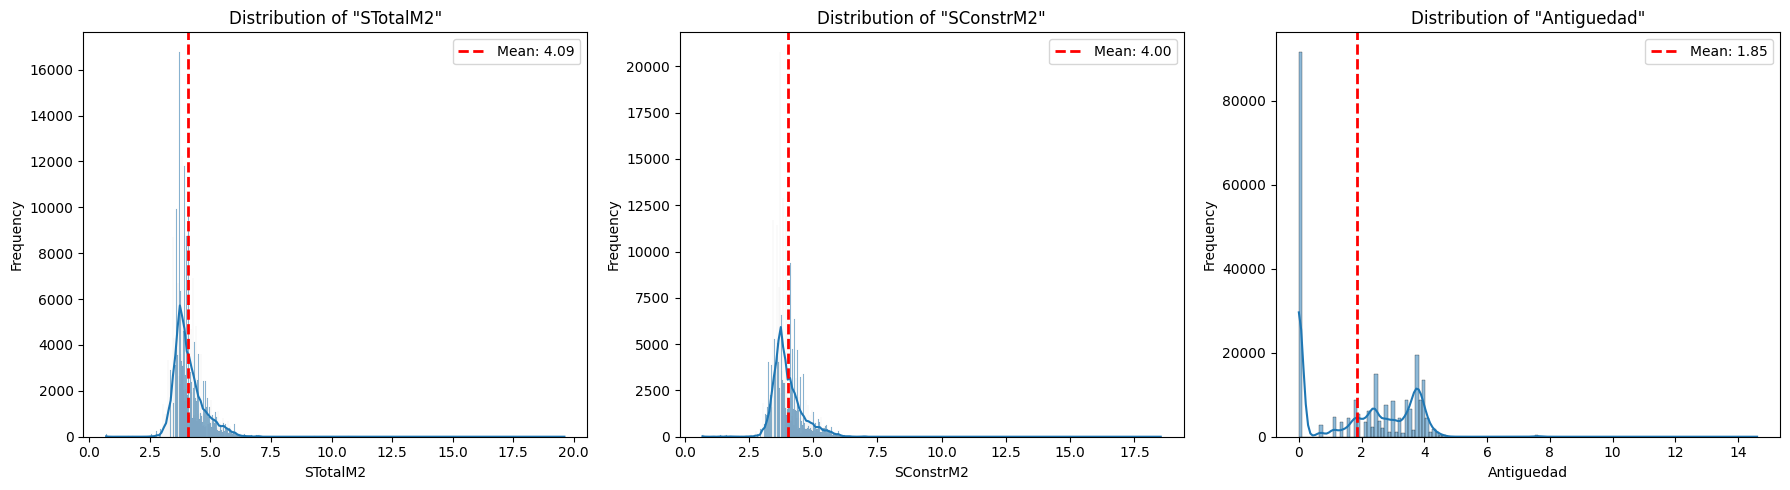

In [47]:
OUTLIER_COLS = ["STotalM2", "SConstrM2", "Antiguedad"]
df_log = log_transform_features(df_capped, OUTLIER_COLS)
plot_histograms(df_log, OUTLIER_COLS)

La situación mejoró, pero siguen habiendo valores demasiado extremos que probablemente se correspondan a errores de medición (por ejemplo para superficie, hay valores demasiado grandes que podrían corresponderse con la superficie del edificio entero en lugar de la propiedad). Para Antiguedad, el valor máximo es alrededor de 500 años lo cual podría no ser un error. Entonces, cappeemos los outliers extremos en superficie

Capping outliers for columns: STotalM2, SConstrM2


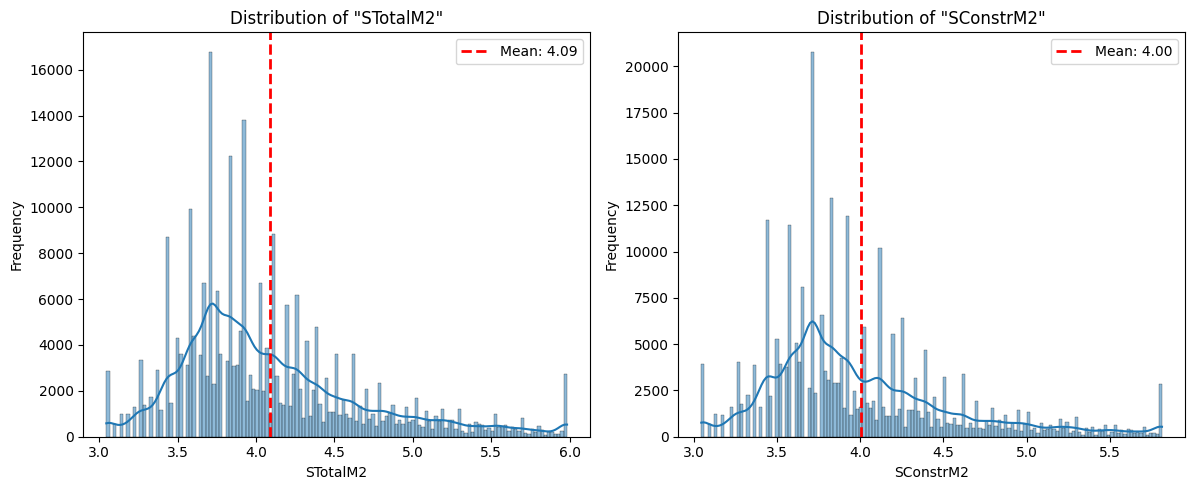

In [48]:
SUP_COLS = ["STotalM2", "SConstrM2"]
df_sup_capped, _ = cap_outliers(df_log, SUP_COLS, percentiles=(0.01, 0.99))
plot_histograms(df_sup_capped, SUP_COLS)

Ahora sí las distribuciones son más gaussianas lo cual va a ayudar a nuestros modelos. Finalmente, apliquemos una estandarización para que los datos se parezcan más a una normal estándar y tengan magnitudes similares:

Standardizing columns: id_grid, STotalM2, SConstrM2, Antiguedad, LONGITUDE, LATITUDE


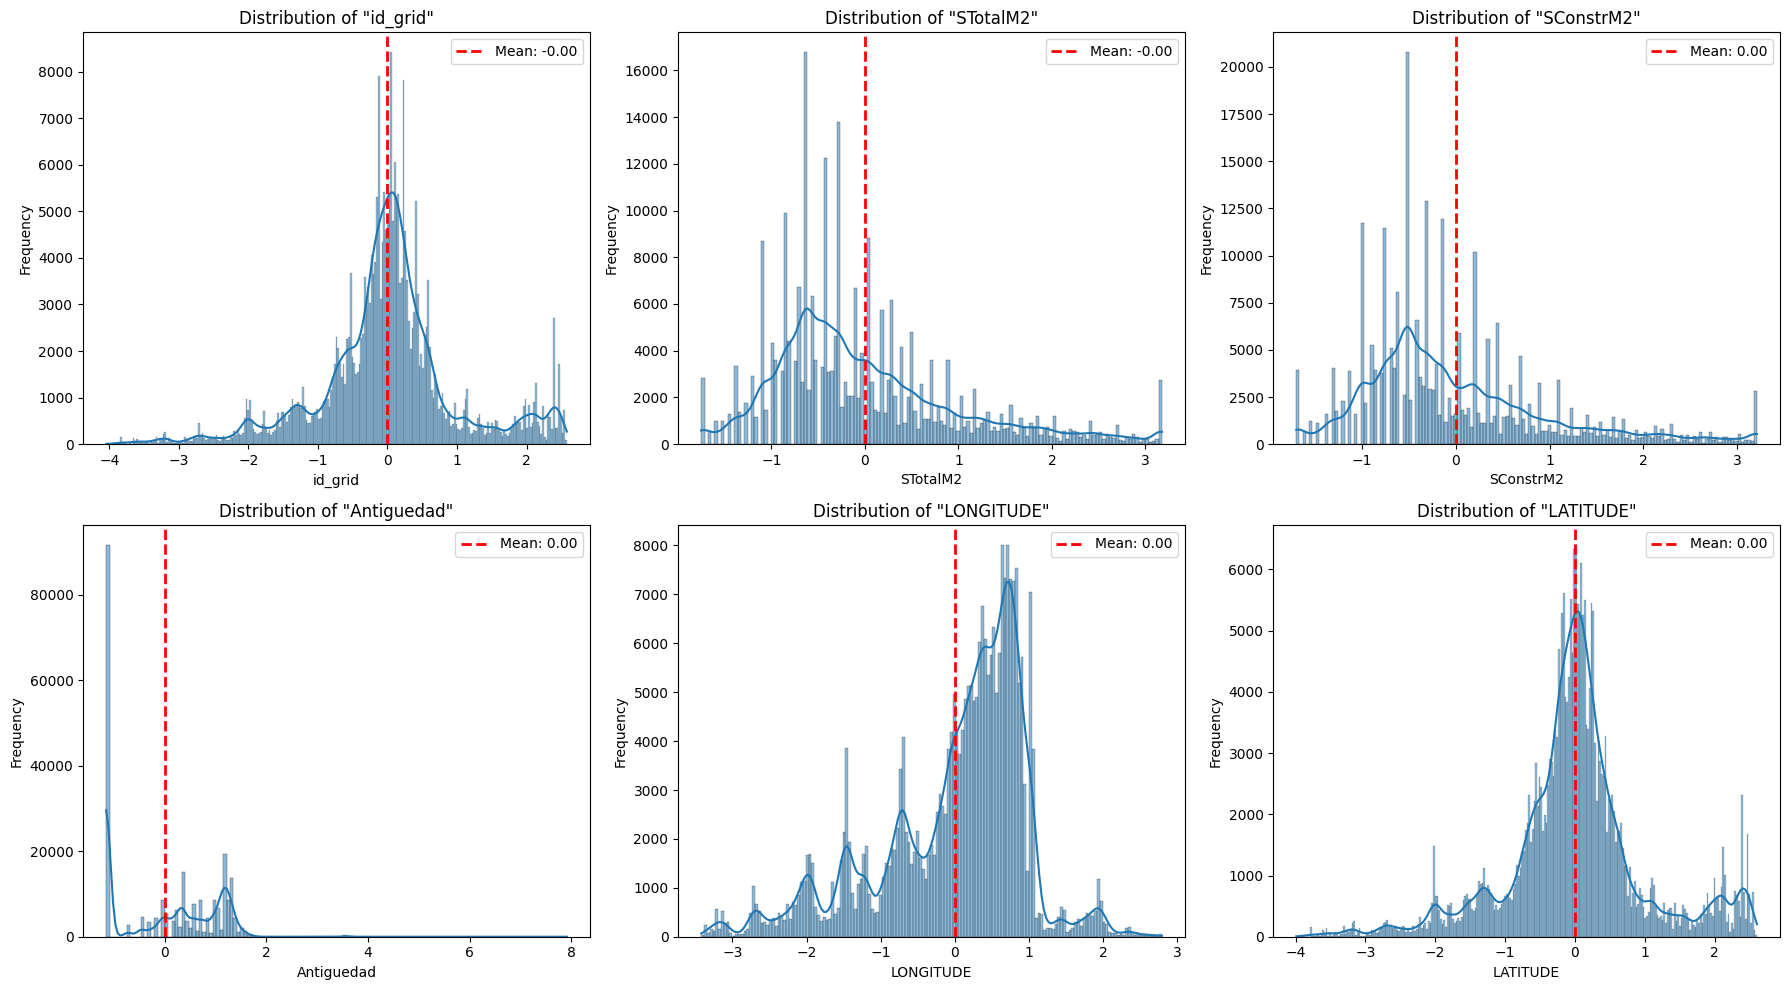

In [49]:
df_std, _ = standardize_features(df_sup_capped, NUMERICAL_FEATURES)
plot_histograms(df_std, NUMERICAL_FEATURES)

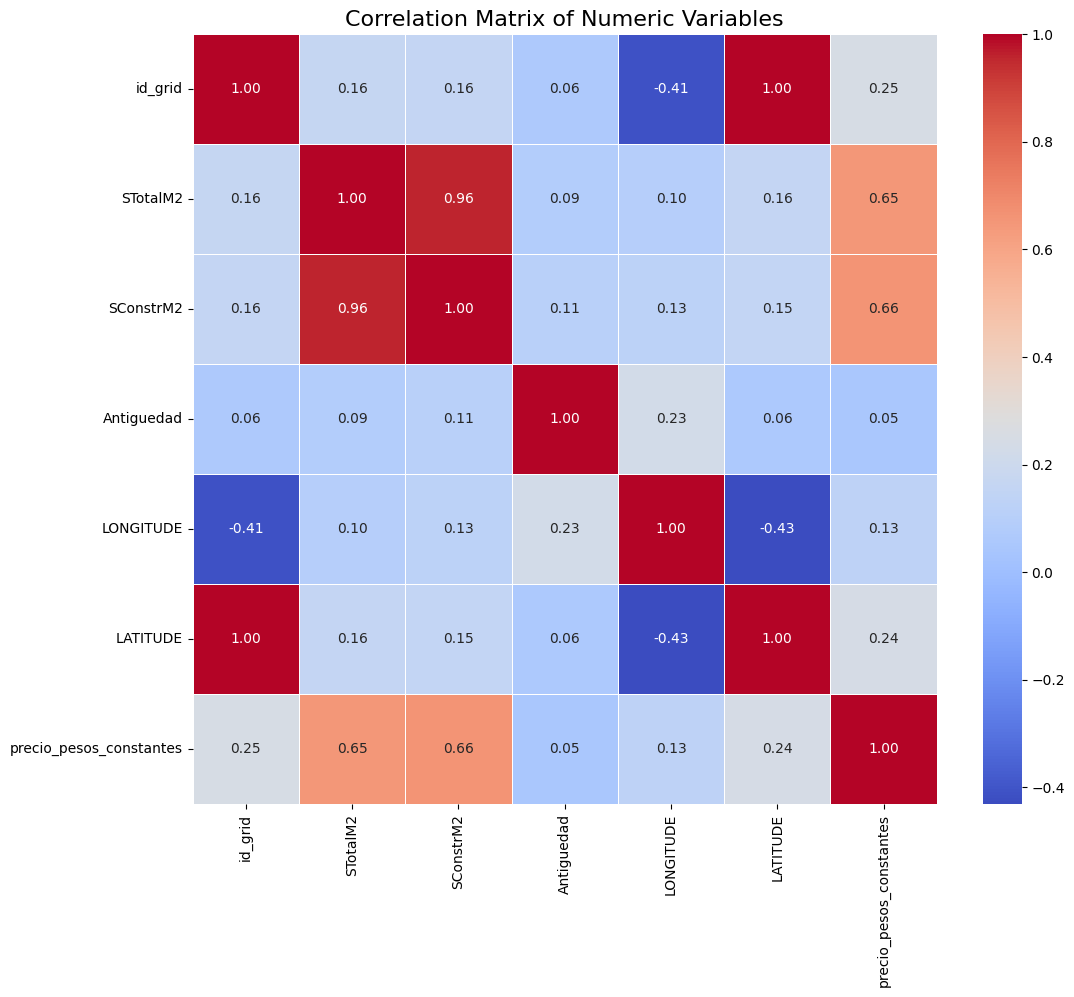

In [50]:
plot_correlation_heatmap(df_std, NUMERICAL_FEATURES + [TARGET])

Ahora sí la matriz de heatmap empieza a mostrar algunas correlaciones, especialmente en las features de superficie. Estas dos están altamente correlacionadas entre sí, lo cual nos indica que probablemente contengan información muy redundante y quizás podamos sacar a una de ellas.

Las features de ubicación (id_grid, longitud, latitud) muestran algo de correlación. La única que parece no aportar casi nada es Antiguedad
- Otra cosa a notar es que id_grid tiene una correlación del 100% con latitud. Esto probablemente signifique que el id del polígono sea exactamente igual que la latitud, y nos podamos deshacer de el

Conclusiones:
- Eliminar Antiguedad y id_grid ya que no aportan al problema
- Eliminar SConstrM2 ya que contiene información casi idéntica a STotalM2

## Análisis de Features Categóricas

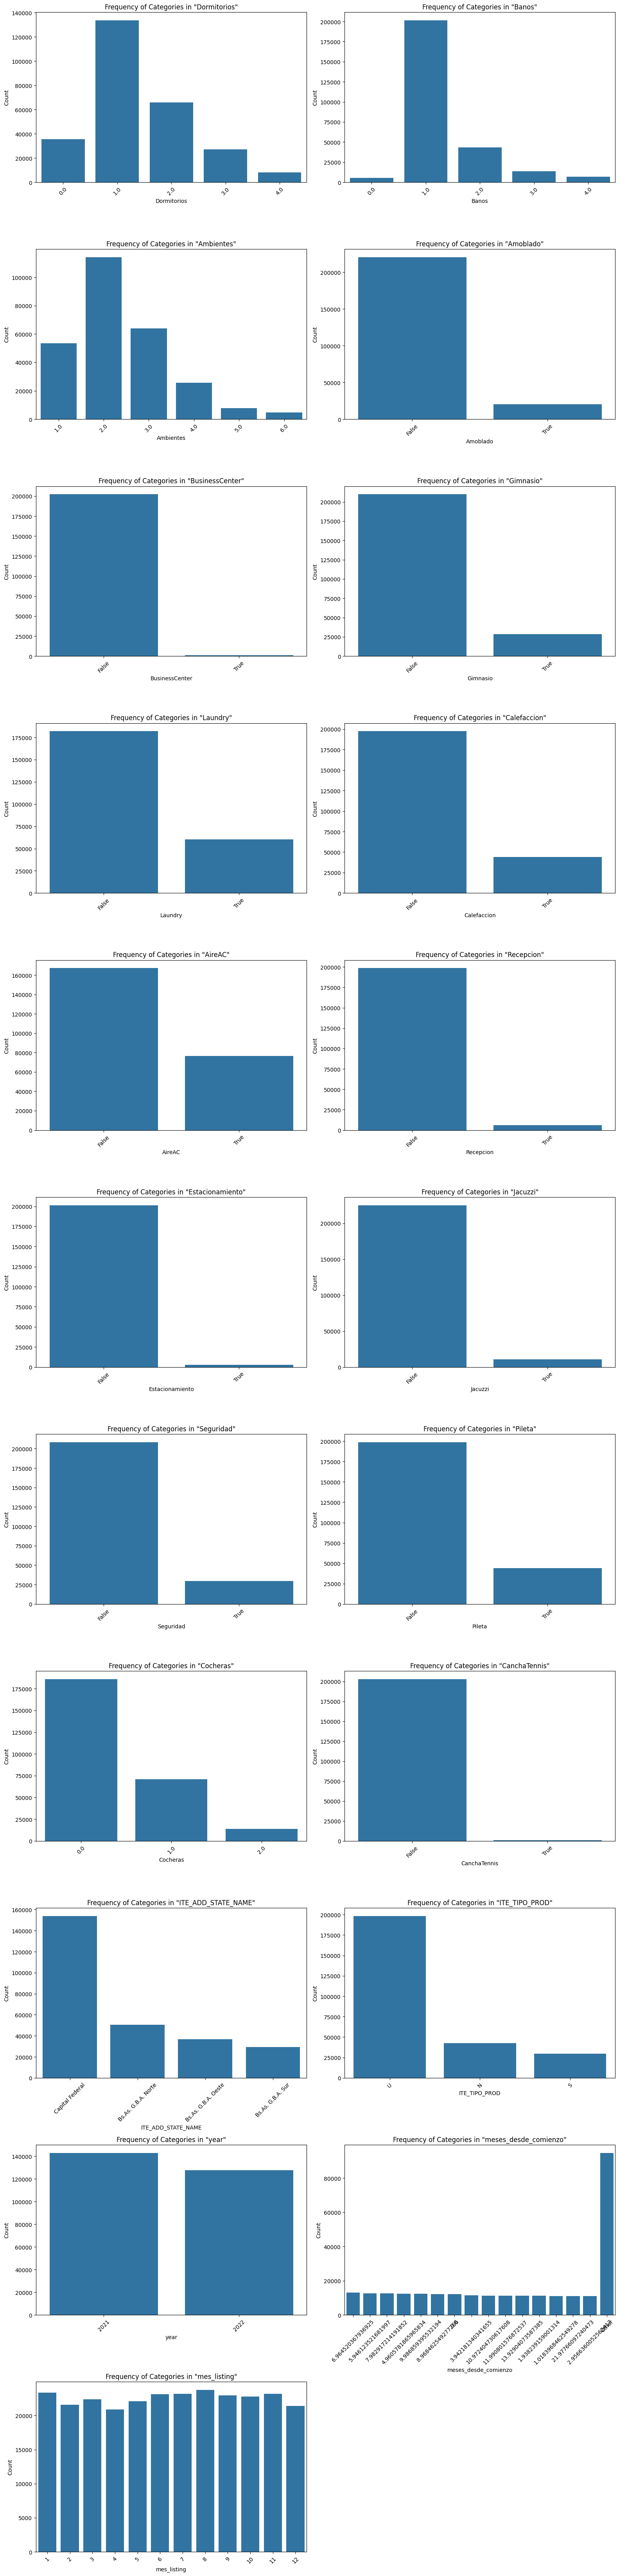

In [51]:
plot_bar_charts(df_std, CATEGORICAL_FEATURES)

Insights:
- Variables booleanas muy desbalanceadas. Especialmente algunas relacionadas con amenities de lujo, tienen un desbalance extremo, donde solo están presentes en algunas pocas propiedades. Una opción para manejar esto puede ser unificar todas las columnas relacionadas con amenities de lujo en una sola.
- Otras variables categoricas como Ambientes y Dormitorios tienen una forma aproximadamente gaussiana. Probablemente no sean un problema.

Comparemos el impacto que tiene cada una de las features booleanas sobre el precio
- La métrica que se va a utilizar es la diferencia de medianas entre las muestras que son True y las muestras que son False. Cuanto más grande es la diferencia entre medianas, podemos decir que más grande es el impacto que tiene la feature sobre el precio
- Se agrega una nueva feature llamada LuxuryAmenities que es un OR entre las siguientes features booleanas: BusinessCenter OR  Recepcion OR Estacionamiento OR Jacuzzi OR CanhaTennis.

In [54]:
luxury_amenities_cols = [
    'BusinessCenter',
    'Recepcion',
    'Estacionamiento',
    'Jacuzzi',
    'CanchaTennis'
]

existing_cols = [col for col in luxury_amenities_cols if col in df_std.columns]

if existing_cols:
    new_feature = df_std[existing_cols[0]].fillna(False)

    for col in existing_cols[1:]:
        new_feature = new_feature | df_std[col].fillna(False).astype(bool)

    df_std['LuxuryAmenities'] = new_feature

    print("Nueva feature 'LuxuryAmenities' creada.")
    print("\nDistribución de la nueva feature:")
    print(df_std['LuxuryAmenities'].value_counts())

else:
    print("⚠️ Ninguna de las columnas para crear 'LuxuryAmenities' fue encontrada.")

df_std.head()

✅ Nueva feature 'LuxuryAmenities' creada.

Distribución de la nueva feature:
LuxuryAmenities
False    253355
True      17360
Name: count, dtype: int64


/var/folders/6m/0x8b1d414hzb0yzldr8nbj5r0000gn/T/ipykernel_17092/2279486391.py:16: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  new_feature = df_std[existing_cols[0]].fillna(False)
/var/folders/6m/0x8b1d414hzb0yzldr8nbj5r0000gn/T/ipykernel_17092/2279486391.py:20: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  new_feature = new_feature | df_std[col].fillna(False).astype(bool)
/var/folders/6m/0x8b1d414hzb0yzldr8nbj5r0000gn/T/ipykernel_17092/2279486391.py:20: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will ch

,id_grid,STotalM2,SConstrM2,Dormitorios,Banos,Ambientes,Amoblado,Antiguedad,BusinessCenter,Gimnasio,...,ITE_ADD_NEIGHBORHOOD_NAME,ITE_TIPO_PROD,LONGITUDE,LATITUDE,precio_pesos_constantes,year,SUM,meses_desde_comienzo,mes_listing,LuxuryAmenities
0,-0.028580,-0.670158,-0.695719,1.0,1.0,2.0,False,-1.147299,False,False,...,Caseros,N,-0.739700,-0.013327,8.745172,2022,False,18.955322,8,False
1,0.576783,-0.364644,-0.513734,1.0,1.0,2.0,False,0.142595,False,False,...,Núñez,U,0.063416,0.569677,9.298754,2021,False,2.956636,4,False
2,-0.000635,1.291955,0.275715,1.0,1.0,3.0,False,1.156259,False,False,...,NaN,U,0.832954,-0.018061,9.289237,2021,False,7.982917,9,False
3,0.177617,3.175630,3.210143,2.0,3.0,6.0,NaN,1.291643,NaN,False,...,Recoleta,U,0.759267,0.160052,11.720004,2022,NaN,21.977661,11,False
4,-0.134255,2.711758,3.020417,2.0,4.0,6.0,False,-1.147299,False,False,...,Monserrat,U,0.907183,-0.151943,15.858631,2021,False,2.956636,4,False


<string>:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.



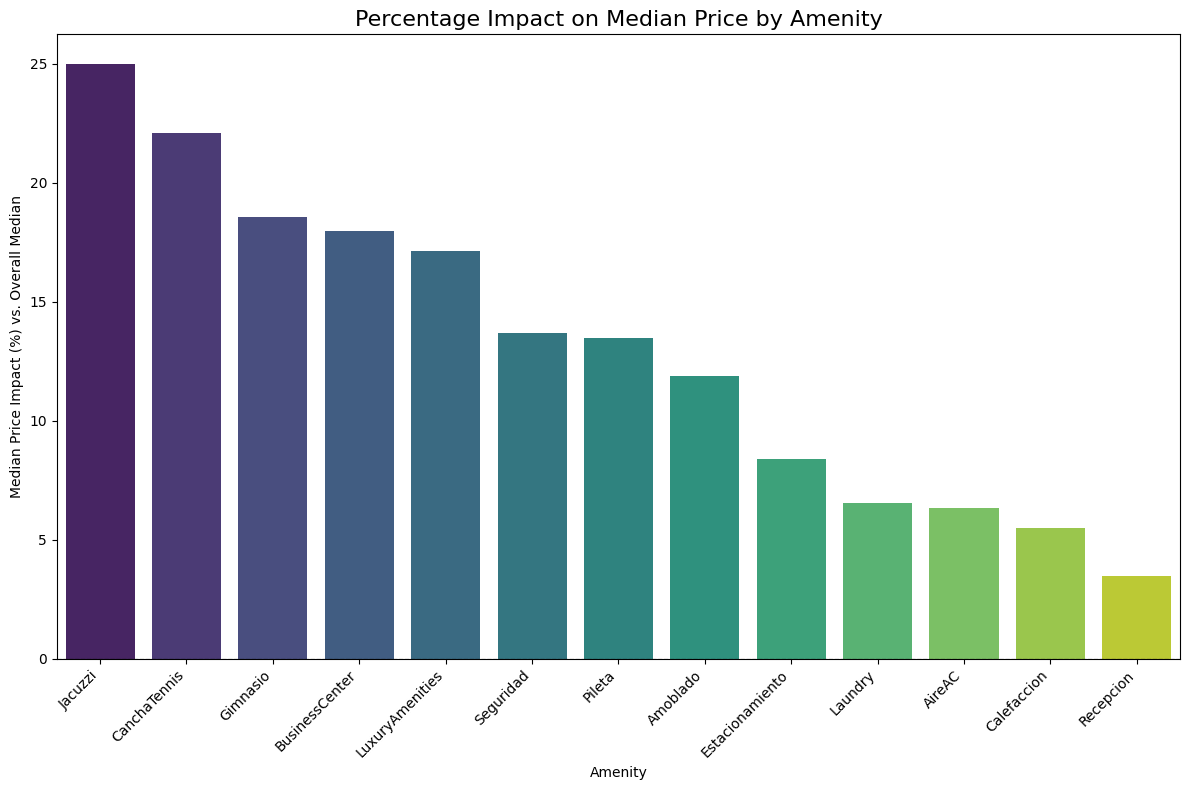

In [66]:
BOOLEAN_COLS = ["Amoblado", "BusinessCenter", "Gimnasio", "Laundry", "Calefaccion", "AireAC", "Recepcion", "Estacionamiento", "Jacuzzi", "Seguridad", "Pileta", "CanchaTennis", "LuxuryAmenities"]
plot_median_price_impact(df_std, BOOLEAN_COLS, TARGET)

Insights:
- Recepcion aplica a muy pocas propiedades y tiene muy bajo impacto. La eliminamos
- Amenities de lujo (Jacuzzi, CanchaTennis) tienen el mayor impacto sobre el precio, lo cual es esperables. Vamos a juntar todos los amenities de lujo (eliminando completamente recepcion, y manteniendo estacionamiento separado ya que no pareciera ser de lujo) en LuxuryAmenities

<string>:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

<string>:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

<string>:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

<string>:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

<string>:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

<string>:22: FutureW

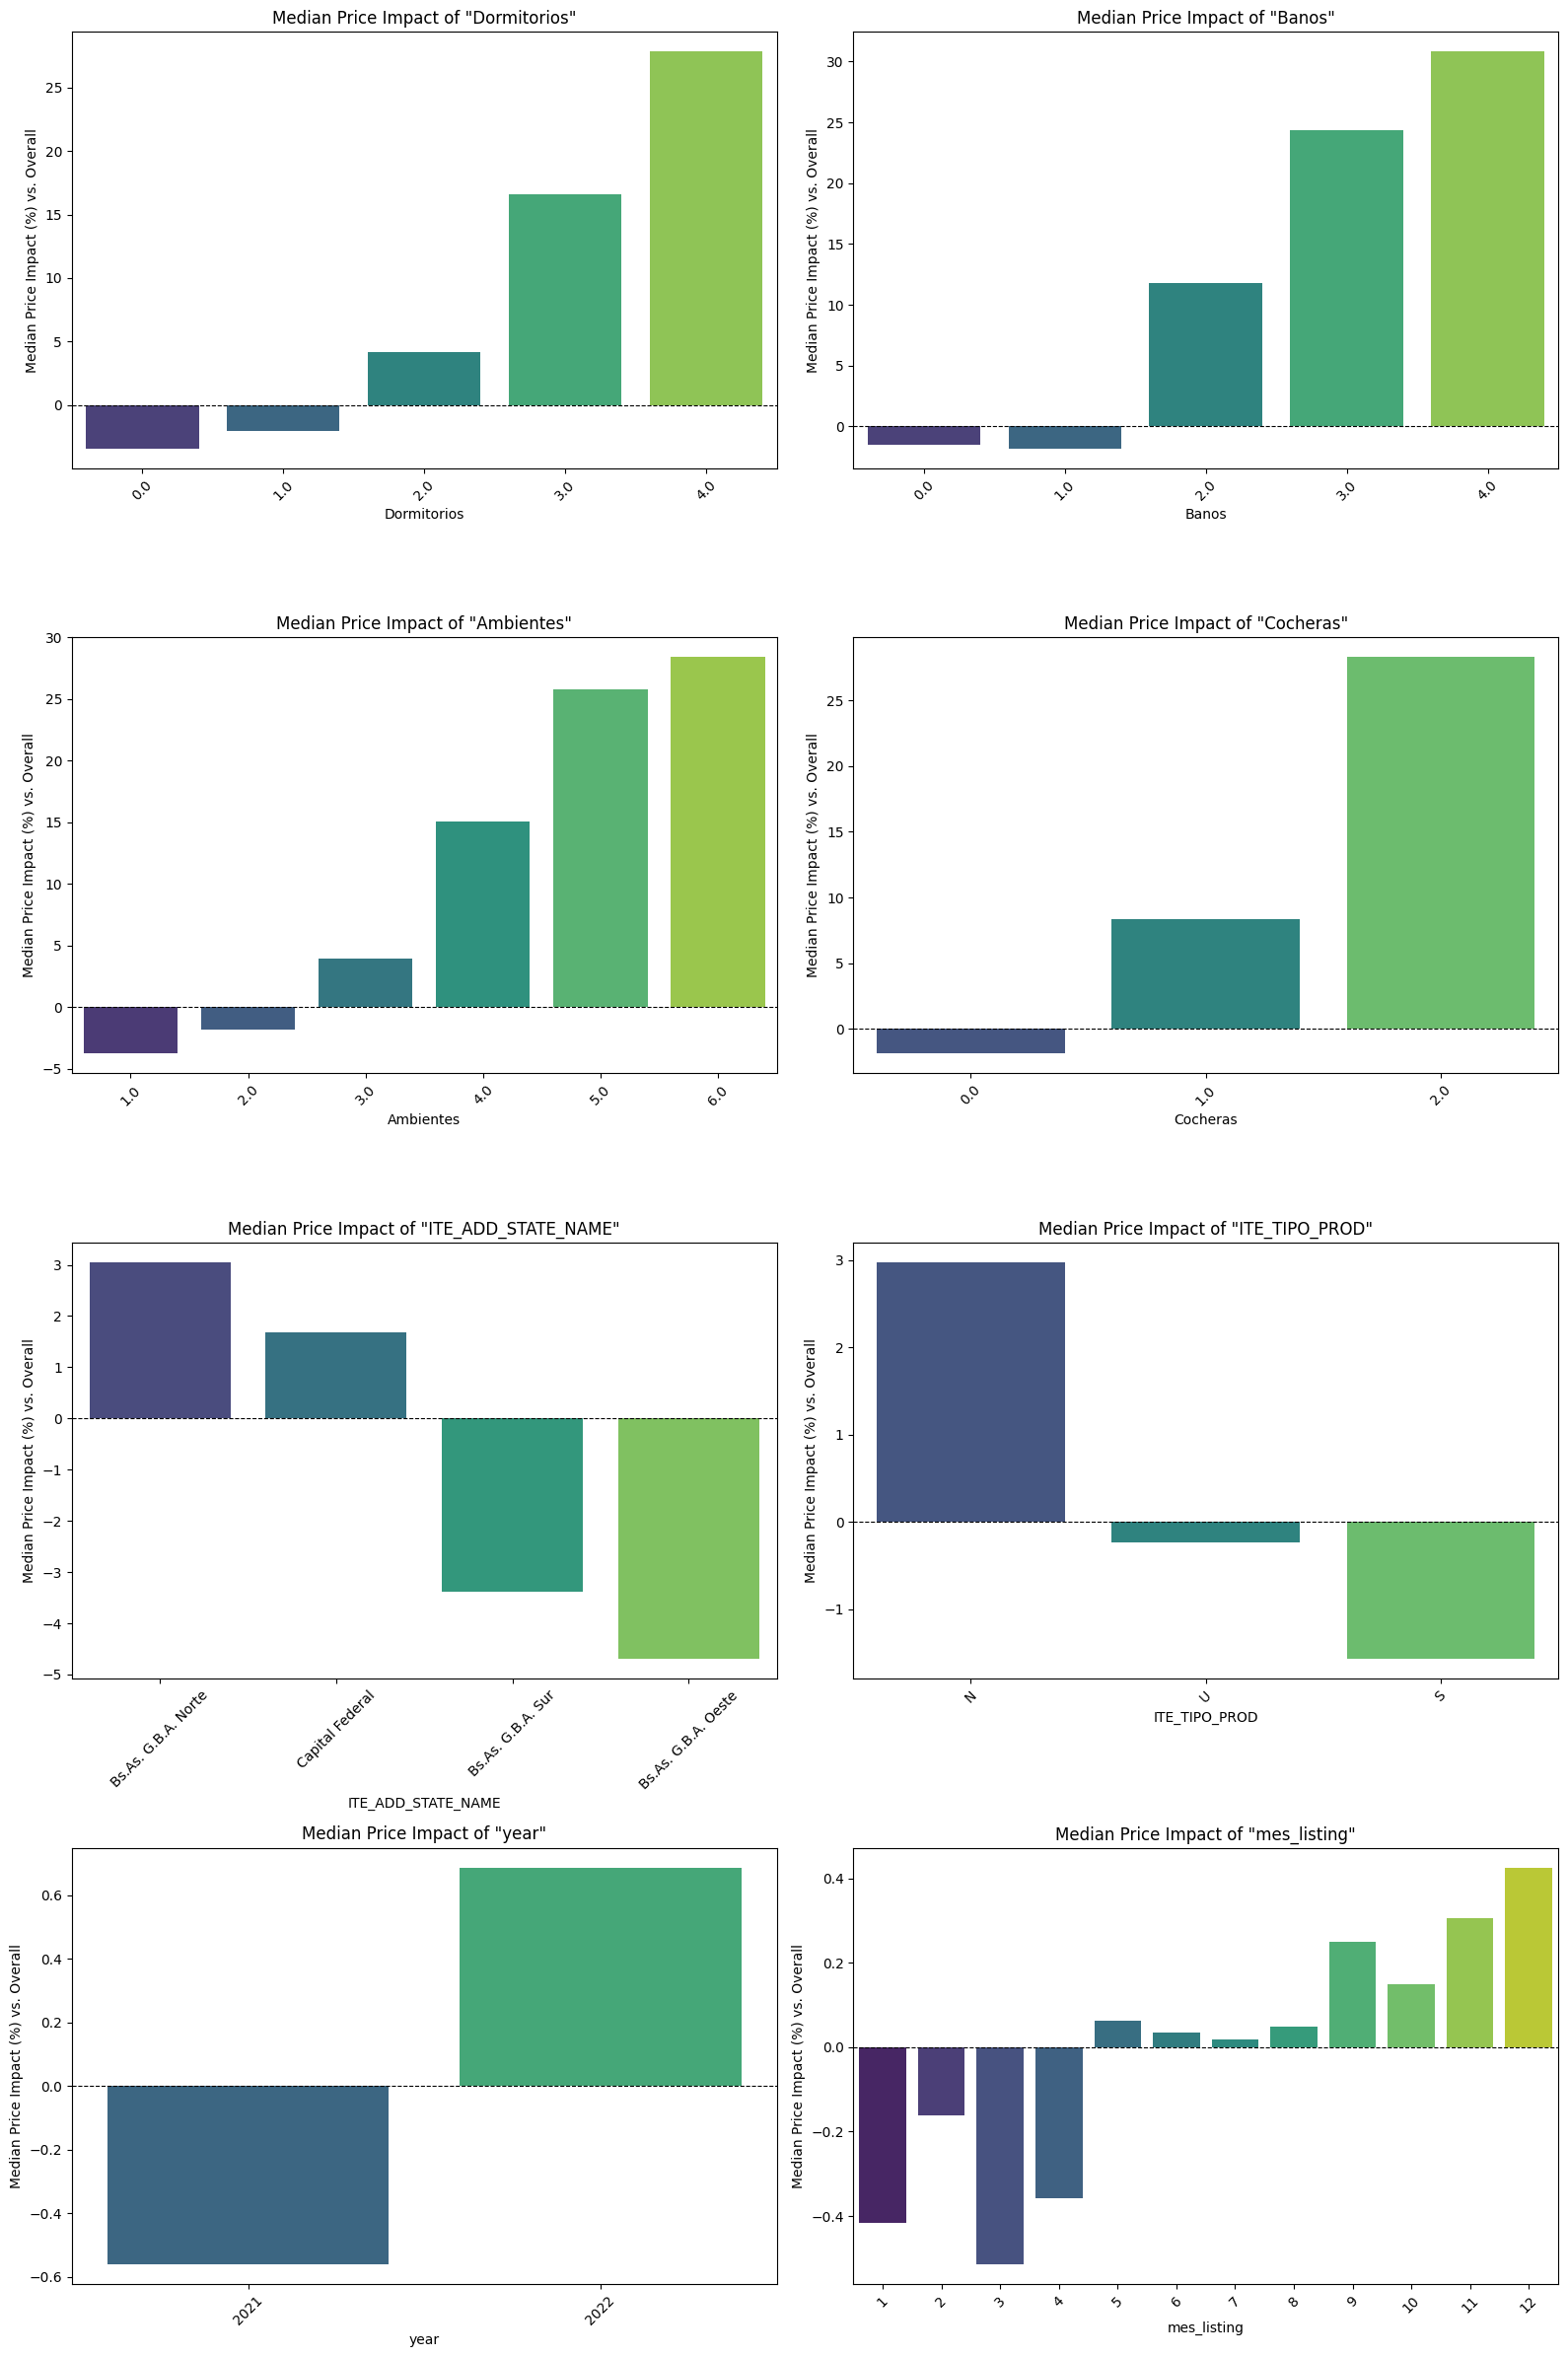

In [69]:
PURELY_CATEGORICAL_COLS=["Dormitorios", "Banos", "Ambientes", "Cocheras", "ITE_ADD_STATE_NAME", "ITE_TIPO_PROD", "year", "mes_listing"]
plot_categorical_impact(df_std, PURELY_CATEGORICAL_COLS, TARGET)

Insights:
- Una mayor cantidad de dormitorios, baños, ambientes y cocheras tiende a subir el precio
- Las propiedades de tipo N tienen un precio algo mayor que el promedio, y las propiedades de tipo S un precio ligeramente menor
- La categoría de zonas muestra claramente como las propiedades de Zona Norte son las más costosas, seguidas por CABA, Zona sur y Zona Oeste
- Los precios subieron en un pequeño porcentaje de 2021 a 2022
- Ppareciera haber una muy leve correlacion entre el mes del año en el que se publicó la propiedad y el precio

## Análisis Geoespacial

Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.


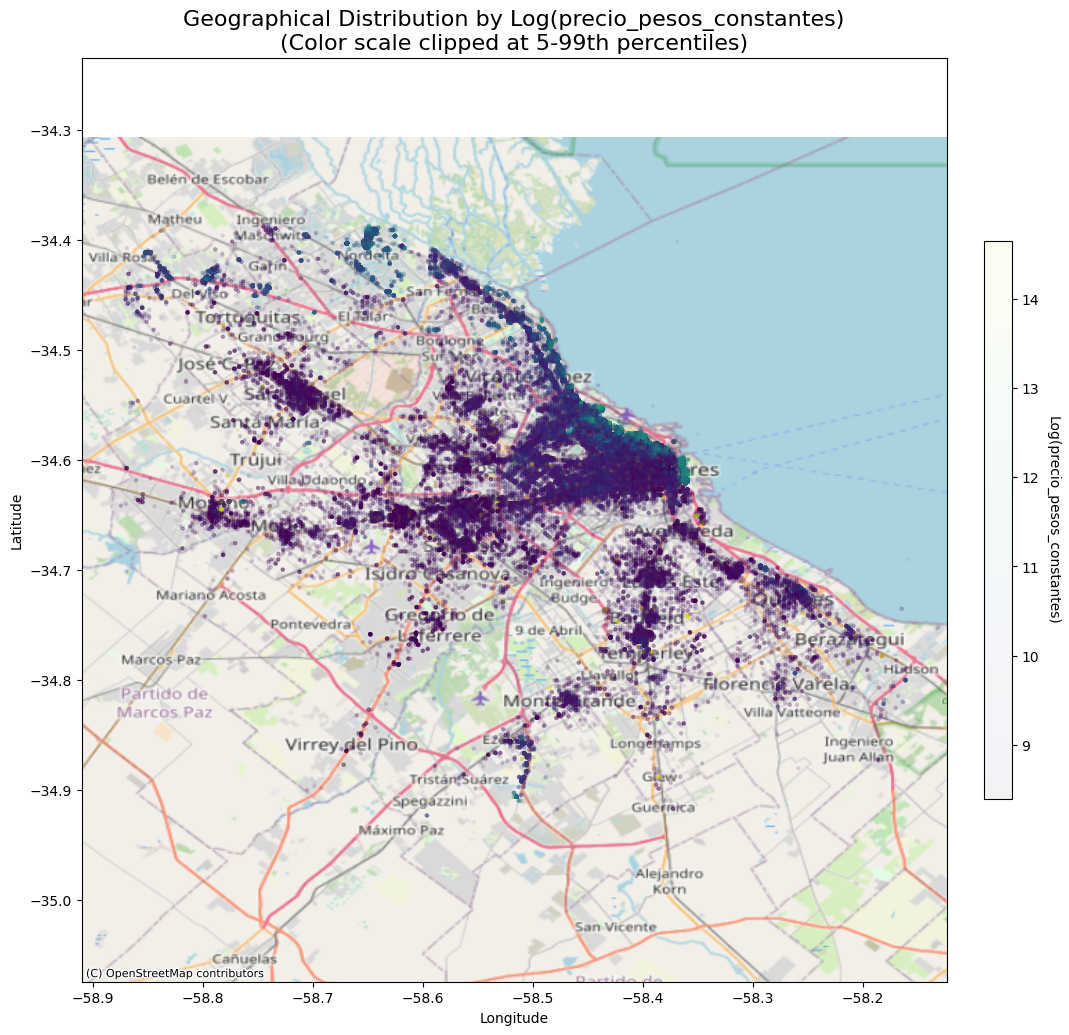

In [26]:
plot_geo_scatterplot(
    df,
    geo_cols=("LONGITUDE", "LATITUDE"),
    color_col=TARGET,
    log_scale=True,
    clip_percentiles=(0.05, 0.99),
    cmap='viridis',
    add_basemap=True,
    alpha=0.05
)